<a href="https://colab.research.google.com/github/ary4m4n03/Golden-Harvesting-A-Predictive-Model-for-Apple-Quality-Assurance/blob/main/Golden_Harvesting_A_Predictive_Model_for_Apple_Quality_Assurance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import and Read Dataset from Git

In [1]:
import os
if not os.path.exists("Golden-Harvesting-A-Predictive-Model-for-Apple-Quality-Assurance"):
    !git clone https://github.com/ary4m4n03/Golden-Harvesting-A-Predictive-Model-for-Apple-Quality-Assurance.git
%cd Golden-Harvesting-A-Predictive-Model-for-Apple-Quality-Assurance


Cloning into 'Golden-Harvesting-A-Predictive-Model-for-Apple-Quality-Assurance'...
remote: Enumerating objects: 25, done.
remote: Counting objects: 100% (25/25), done.
remote: Compressing objects: 100% (21/21), done.
remote: Total 25 (delta 5), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (25/25), 179.84 KiB | 3.83 MiB/s, done.
Resolving deltas: 100% (5/5), done.
/content/Golden-Harvesting-A-Predictive-Model-for-Apple-Quality-Assurance


Import Libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import xgboost as xgb
import pickle

Style for plots

In [3]:
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

Read Dataset

In [19]:
data = pd.read_csv("apple_quality.csv")
print("Dataset loaded successfully.")
print("Shape of the dataset:", data.shape)


Dataset loaded successfully.
Shape of the dataset: (4000, 9)


Data Preprocessing


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   A_id         4000 non-null   int64  
 1   Size         4000 non-null   float64
 2   Weight       4000 non-null   float64
 3   Sweetness    4000 non-null   float64
 4   Crunchiness  4000 non-null   float64
 5   Juiciness    4000 non-null   float64
 6   Ripeness     4000 non-null   float64
 7   Acidity      4000 non-null   float64
 8   Quality      4000 non-null   object 
dtypes: float64(7), int64(1), object(1)
memory usage: 281.4+ KB
None

First few rows:
   A_id      Size    Weight  Sweetness  Crunchiness  Juiciness  Ripeness  \
0     0 -3.970049 -2.512336   5.346330    -1.012009   1.844900  0.329840   
1     1 -1.195217 -2.839257   3.664059     1.588232   0.853286  0.867530   
2     2 -0.292024 -1.351282  -1.738429    -0.342616   2.838636 -0.038033   
3     3 -0.657196 -2.271627

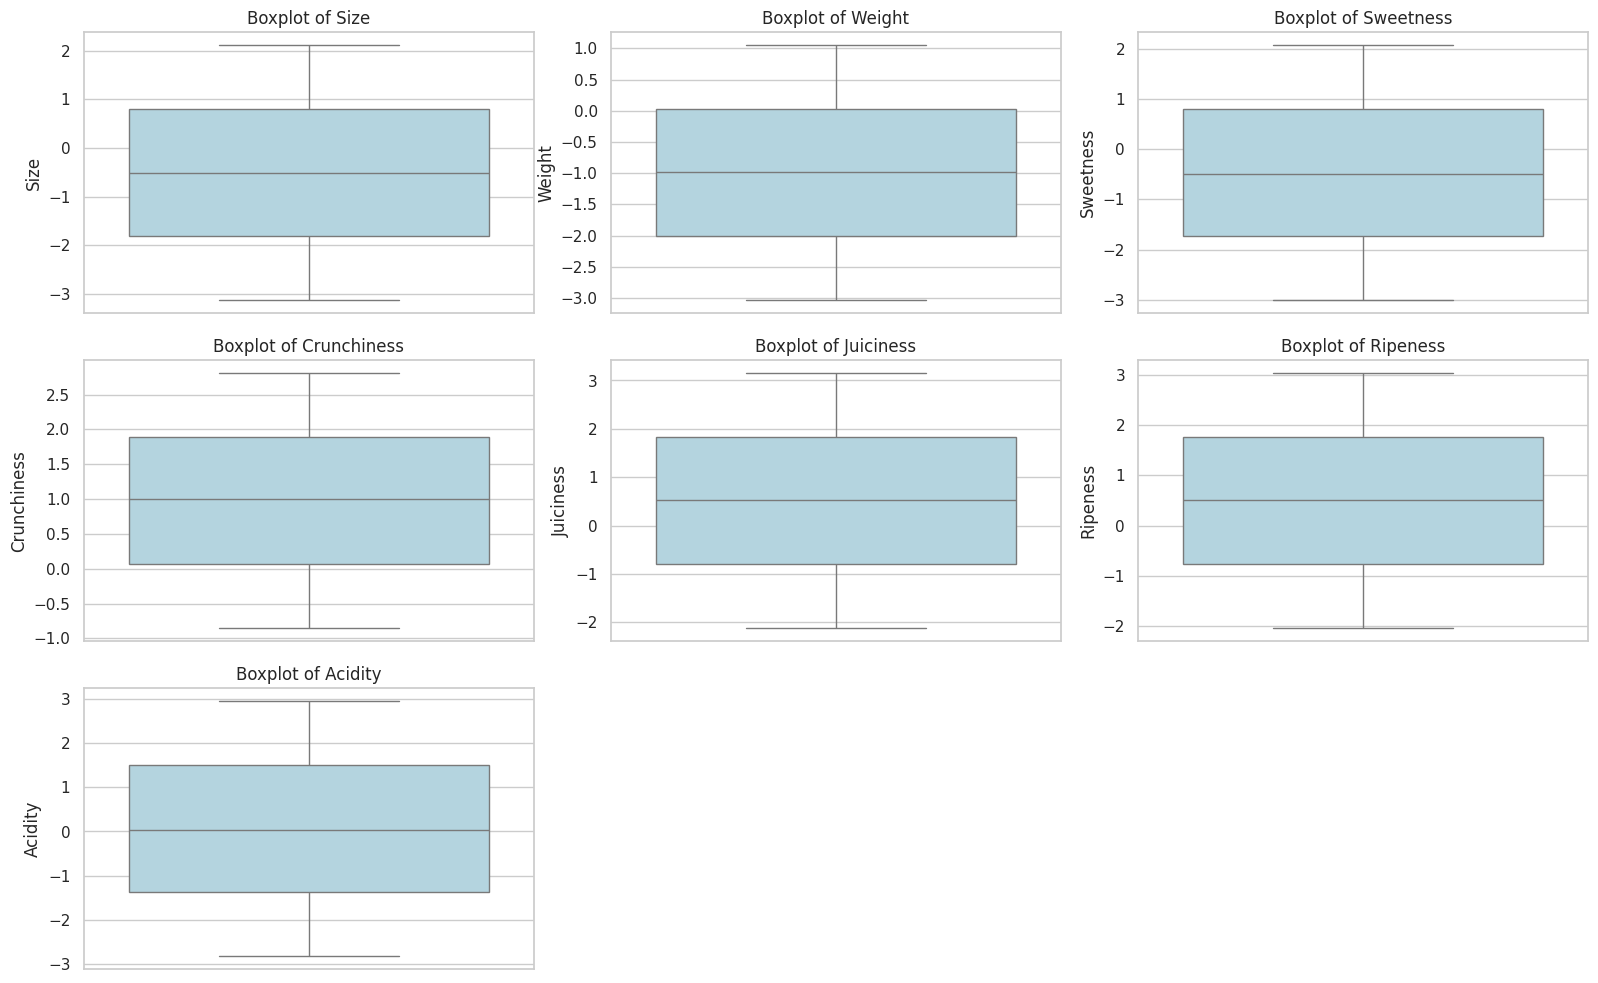

<ipython-input-20-1868037807>:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Quality', data=data, palette='pastel')


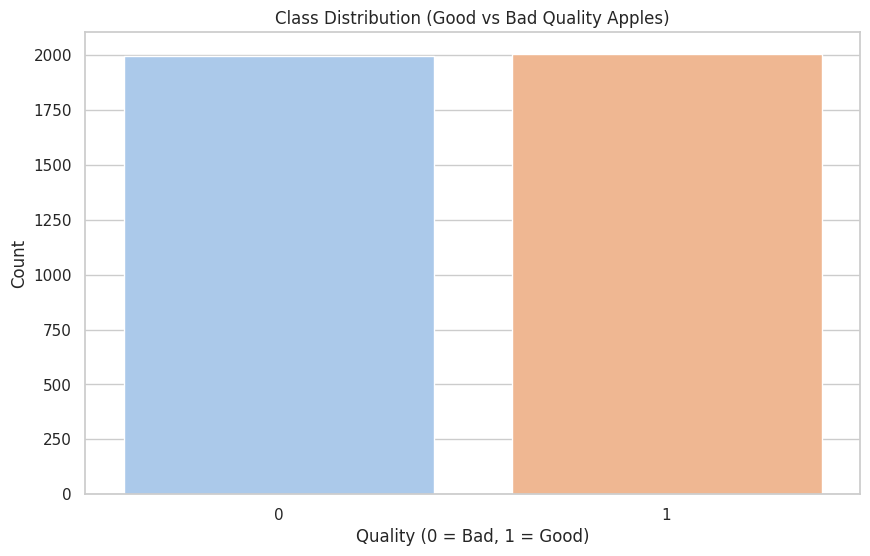


Class Distribution:
 Quality
1    2004
0    1996
Name: count, dtype: int64

Final cleaned dataset shape: (4000, 9)

Sample preview of cleaned data:
   A_id      Size    Weight  Sweetness  Crunchiness  Juiciness  Ripeness  \
0     0 -3.127910 -2.512336   2.072095    -0.852971   1.844900  0.329840   
1     1 -1.195217 -2.839257   2.072095     1.588232   0.853286  0.867530   
2     2 -0.292024 -1.351282  -1.738429    -0.342616   2.838636 -0.038033   
3     3 -0.657196 -2.271627   1.324874    -0.097875   3.154607 -2.040621   
4     4  1.364217 -1.296612  -0.384658    -0.553006   3.030874 -1.303849   

    Acidity  Quality  
0 -0.491590        1  
1 -0.722809        1  
2  2.621636        0  
3  0.790723        1  
4  0.501984        1  


In [20]:
#initial exploration
print("\nDataset Info:")
print(data.info())
print("\nFirst few rows:")
print(data.head())

#handling missing values
print("\nMissing Values(per column):")
print(data.isnull().sum())
data = data.dropna()
print("\nAfter dropping missing values, shape:",data.shape)

#handling categorical data
data['Quality']=data['Quality'].astype('category').cat.codes
print("\nEncoded 'Quality' values:\n", data['Quality'].value_counts())
data['Acidity']=pd.to_numeric(data['Acidity'],errors='coerce')
data = data.dropna()
print("\nAfter converting 'Acidity', new shape:",data.shape)

#outlier handling via IQR
def cap_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    df[column] = np.where(df[column] > upper, upper,
                  np.where(df[column] < lower, lower, df[column]))
    return df
numeric_cols = ['Size', 'Weight', 'Sweetness', 'Crunchiness', 'Juiciness', 'Ripeness', 'Acidity']
for col in numeric_cols:
    data = cap_outliers(data, col)

plt.figure(figsize=(16, 10))
for i, col in enumerate(numeric_cols, 1):
    plt.subplot(3, 3, i)
    sns.boxplot(y=data[col], color="lightblue")
    plt.title(f"Boxplot of {col}")
plt.tight_layout()
plt.show()

#class balance check
sns.countplot(x='Quality', data=data, palette='pastel')
plt.title("Class Distribution (Good vs Bad Quality Apples)")
plt.xlabel("Quality (0 = Bad, 1 = Good)")
plt.ylabel("Count")
plt.show()
print("\nClass Distribution:\n", data['Quality'].value_counts())

#overview
print("\nFinal cleaned dataset shape:", data.shape)
print("\nSample preview of cleaned data:")
print(data.head())

Exploratory Data Analysis

In [6]:
data.describe()

,A_id,Size,Weight,Sweetness,Crunchiness,Juiciness,Ripeness,Acidity,Quality
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,1999.500000,-0.502695,-0.991229,-0.472248,0.984194,0.513127,0.498102,0.076639,0.501000
std,1154.844867,1.917446,1.574517,1.931684,1.369437,1.917024,1.866614,2.101441,0.500062
min,0.000000,-5.750201,-5.075890,-5.548946,-2.684440,-4.757179,-4.578510,-5.709299,0.000000
25%,999.750000,-1.816765,-2.011770,-1.738425,0.062764,-0.801286,-0.771677,-1.377424,0.000000
50%,1999.500000,-0.513703,-0.984736,-0.504758,0.998249,0.534219,0.503445,0.022609,1.000000
75%,2999.250000,0.805526,0.030976,0.801922,1.894234,1.835976,1.766212,1.510493,1.000000
max,3999.000000,4.738963,3.095097,4.612442,4.641439,5.791870,5.573044,5.842368,1.000000


Text(0.5, 1.0, 'Disturbution of Data')

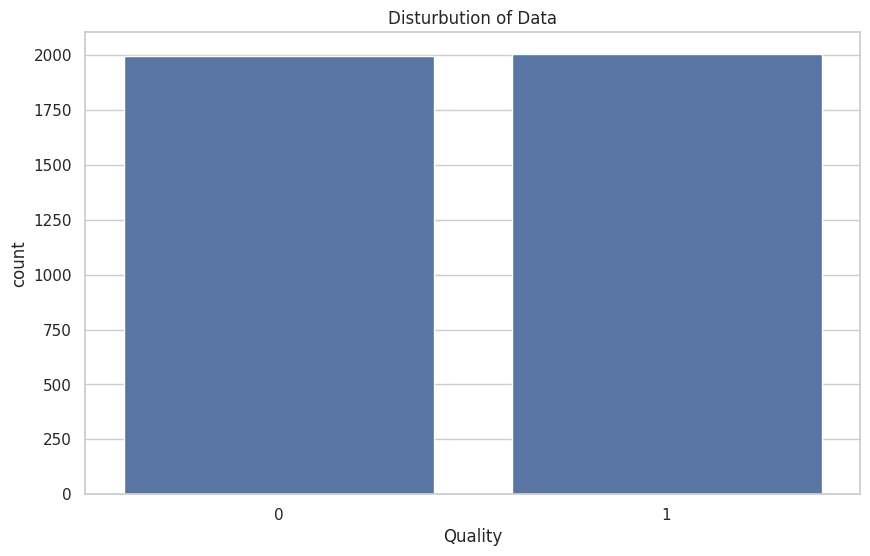

In [7]:
sns.countplot(x='Quality',data=data)
plt.title('Disturbution of Data')

In [9]:
data.corr()

,A_id,Size,Weight,Sweetness,Crunchiness,Juiciness,Ripeness,Acidity,Quality
A_id,1.000000,-0.028722,-0.005954,-0.001819,-0.013516,0.005579,0.000252,-0.022019,0.004875
Size,-0.028722,1.000000,-0.166974,-0.324412,0.169820,-0.019437,-0.135910,0.196334,0.244522
Weight,-0.005954,-0.166974,1.000000,-0.152070,-0.095068,-0.092135,-0.243678,0.019696,0.000167
Sweetness,-0.001819,-0.324412,-0.152070,1.000000,-0.033874,0.095436,-0.273578,0.084710,0.250890
Crunchiness,-0.013516,0.169820,-0.095068,-0.033874,1.000000,-0.257884,-0.200391,0.071793,-0.012204
Juiciness,0.005579,-0.019437,-0.092135,0.095436,-0.257884,1.000000,-0.098975,0.248688,0.260135
Ripeness,0.000252,-0.135910,-0.243678,-0.273578,-0.200391,-0.098975,1.000000,-0.201941,-0.264687
Acidity,-0.022019,0.196334,0.019696,0.084710,0.071793,0.248688,-0.201941,1.000000,-0.007634
Quality,0.004875,0.244522,0.000167,0.250890,-0.012204,0.260135,-0.264687,-0.007634,1.000000


<Axes: >

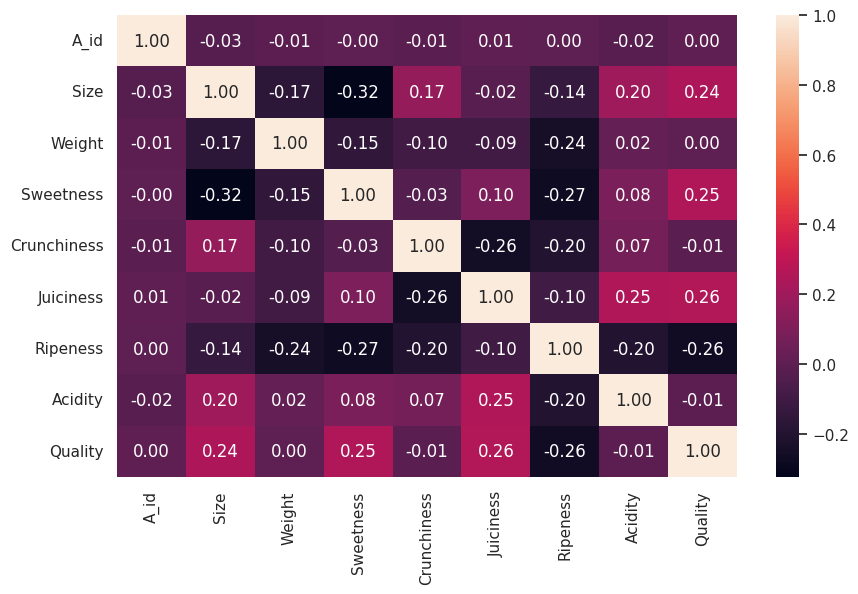

In [10]:
sns.heatmap(data.corr(), annot=True, fmt=".2f")

Splitting Data and Feature Scaling

In [21]:
X=data.drop(['A_id', 'Quality'], axis=1)
y=data['Quality']

scaler=StandardScaler()
X=scaler.fit_transform(X)

X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.2, random_state=42)

Model Building

In [22]:
#Decision Tree
DT=DecisionTreeClassifier(random_state=42)
DT.fit(X_train, y_train)
DT_pred=DT.predict(X_test)
acc=accuracy_score(y_test,DT_pred)
print(acc)

#Random Forest
RF=RandomForestClassifier(n_estimators=100)
RF.fit(X_train, y_train)
RF_pred=RF.predict(X_test)
acc=accuracy_score(y_test,RF_pred)
print(acc)

#XGB
XGB=xgb.XGBClassifier()
XGB.fit(X_train, y_train)
XGB_pred=XGB.predict(X_test)
acc=accuracy_score(y_test,XGB_pred)
print(acc)

#Logistic Regression
LR=LogisticRegression()
LR.fit(X_train, y_train)
LR_pred=LR.predict(X_test)
acc=accuracy_score(y_test,LR_pred)
print(acc)

0.815
0.9075
0.9075
0.72875


Performance Testing and Hyperparameter Tuning

In [ ]:
#Arunima

Saving Best Model

In [ ]:
pickle.dump(model1,open("best.pkl","wb"))